# Predition Boston Housing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from statsmodels.api import qqplot, add_constant


from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import os

In [2]:
def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [3]:
matplotlib.rc("font", family="NanumGothic")
plt.rcParams['axes.unicode_minus']=False
os.environ['PATH']+=os.pathsep+"~/anaconda3/lib/python3.7/site-packages"

# 1. 데이터 불러오기

    1) 한 row는 한 지역단위에 대한 정보이다.
    2) 1970년대 보스턴은 아직 흑인 인종차별이 존재하던 시대로, 흑인 비율에 대한 집값 변동의 가능성을 찾아봐야겠다.
    3) 산화질소농도와 집값의 관계성을 알아보자.
    4) 서울처럼 강 조망이 가능한 집의 가격이 더 높을까?
    5) 범죄율이 집값에 어떤 영향을 미치는지 알아보자.

In [4]:
bh=pd.read_csv("data/BigData/BOSTON_HOUSING.csv")
bh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
MEDV       506 non-null float64
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


# 2. EDA

In [5]:
bh.isnull().sum()

MEDV       0
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

결측치는 없는 것으로 확인 되었다.

In [6]:
bh.describe().T

,count,mean,std,min,25%,50%,75%,max
MEDV,506.0,22.532806,9.197104,5.00000,17.025000,21.200001,25.000000,50.000000
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.256510,3.677083,88.976196
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.000000,12.500000,100.000000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.690000,18.100000,27.740000
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.000000,0.000000,1.000000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.538000,0.624000,0.871000
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.208500,6.623500,8.780000
AGE,506.0,68.574901,28.148862,2.90000,45.025000,77.500000,94.074999,100.000000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.207450,5.188425,12.126500
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.000000,24.000000,24.000000


MEDV, ZN, B, LSTAT등에 이상치에 대한 조짐이 보인다.

In [7]:
def get_outlier(df=None, column=None, weight =1.5):
     # 이상치의 최저, 최대값을 반환하는 함수
    target = df[column]
    #print(target.shape)
    q_25 = np.percentile(target.values,25)
    q_75 = np.percentile(target.values,75)
    
    iqr = q_75 - q_25
    iqr_weight = iqr * weight
    lowest_val = q_25 - iqr_weight
    highest_val = q_75 +iqr_weight

    return lowest_val, highest_val

전체 데이터 이상치 존재 여부 확인

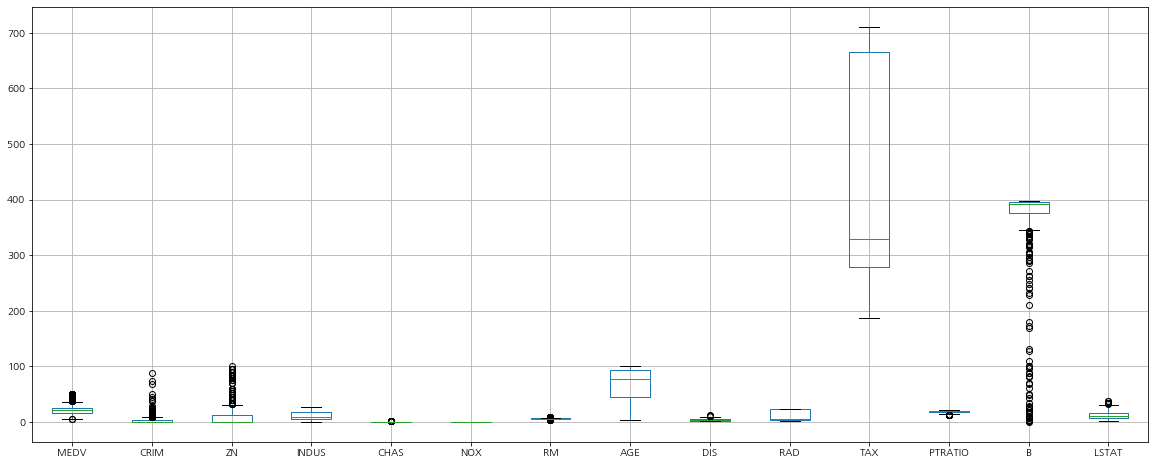

In [8]:
bh.boxplot(figsize=(20,8))

B(흑인 인구비율)의 boxplot에 가장 많은 이상치가 존재하므로 주의깊게 살펴보자

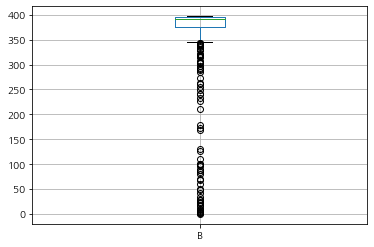

In [9]:
bh.boxplot("B")

In [10]:
bh[bh['B']<344.106].shape

(77, 14)

다른 지역 대비 흑인 인구 비율로 생각한다면 시대적 배경에 따라 이 데이터셋의 B 컬럼에는 실제 이상치라고 판단되는 값을 존재하지 않는다. 

### outlier 범위 확인

In [11]:
mini, maxi=get_outlier(bh,"MEDV")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

5.063보다 작거나 36.962보다 크면 이상치로 판단


In [12]:
mini, maxi=get_outlier(bh,"CRIM")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

-5.311보다 작거나 9.07보다 크면 이상치로 판단


In [13]:
mini, maxi=get_outlier(bh,"ZN")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

-18.75보다 작거나 31.25보다 크면 이상치로 판단


In [14]:
mini, maxi=get_outlier(bh,"CHAS")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

0.0보다 작거나 0.0보다 크면 이상치로 판단


In [15]:
mini, maxi=get_outlier(bh,"RM")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

4.779보다 작거나 7.73보다 크면 이상치로 판단


In [16]:
mini, maxi=get_outlier(bh,"DIS")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

-2.532보다 작거나 9.821보다 크면 이상치로 판단


In [17]:
mini, maxi=get_outlier(bh,"PTRATIO")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

13.2보다 작거나 24.4보다 크면 이상치로 판단


In [18]:
mini, maxi=get_outlier(bh,"B")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

344.106보다 작거나 427.496보다 크면 이상치로 판단


In [19]:
mini, maxi=get_outlier(bh,"LSTAT")
print("{}보다 작거나 {}보다 크면 이상치로 판단".format(mini.round(3), maxi.round(3)))

-8.057보다 작거나 31.962보다 크면 이상치로 판단


변수간의 상관계수 확인

In [20]:
bh.corr().T

,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
MEDV,1.000000,-0.388305,0.360445,-0.483725,0.175260,-0.427321,0.695360,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663
CRIM,-0.388305,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,0.360445,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,-0.483725,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,0.175260,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,-0.427321,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,0.695360,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355502,0.128069,-0.613808
AGE,-0.376955,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,0.249929,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,-0.381626,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676


Text(0.5, 1, 'Correlation between features')

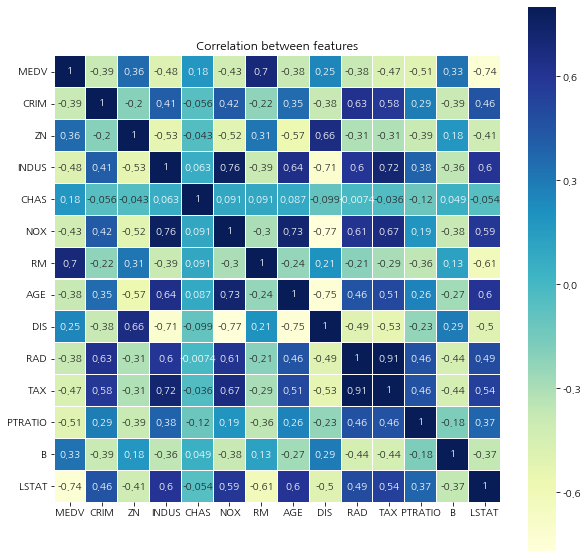

In [21]:
corr=bh.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')

상관계수에 절대값을 씌워 "정도"를 파악해보자.

In [22]:
abs(corr['MEDV']).sort_values()

CHAS       0.175260
DIS        0.249929
B          0.333461
ZN         0.360445
AGE        0.376955
RAD        0.381626
CRIM       0.388305
NOX        0.427321
TAX        0.468536
INDUS      0.483725
PTRATIO    0.507787
RM         0.695360
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

### 가설1. 강이 보이는 집은 가격이 높을 것이다.

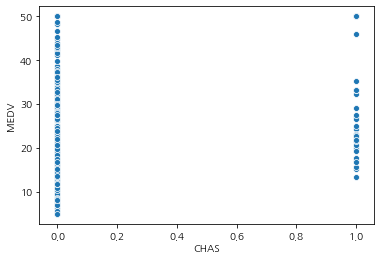

In [23]:
# 강 조망권과 비조망권의 주택가격 분포
sns.scatterplot(x="CHAS", y="MEDV", data=bh)

([<matplotlib.patches.Wedge at 0x7f56d2a4d470>,
 [Text(-1.0741305283228182, 0.23715734887399958, 'NON-REVER VIEW'),
  Text(1.0741305449760203, -0.23715727344848092, 'REVER VIEW')],
 [Text(-0.5858893790851735, 0.1293585539312725, '93.1%'),
  Text(0.5858893881687384, -0.12935851279008048, '6.9%')])

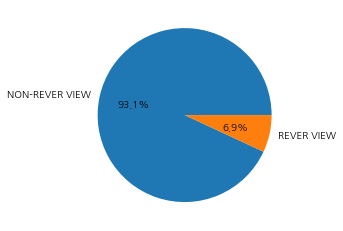

In [24]:
# 강 조망권과 비조망권의 지역 개수 분포
chas=[]
chas.append(len(bh[bh['CHAS']==0]))
chas.append(len(bh[bh['CHAS']==1]))
labels=['NON-REVER VIEW', 'REVER VIEW']
plt.pie(chas,labels=labels ,autopct='%1.1f%%')

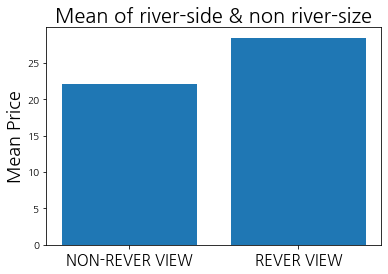

In [25]:
# 강 조망권과 비조망권의 평균 주택가격(중앙값) 비교
index = np.arange(len(labels))

plt.bar(index, bh.groupby('CHAS')['MEDV'].mean())
plt.title('Mean of river-side & non river-size', fontsize=20)
plt.ylabel('Mean Price', fontsize=18)
plt.xticks(index, labels, fontsize=15)
plt.show()

그렇다면 흑인들이 강 조망권에 많이 살고 있는지 확인해보자.

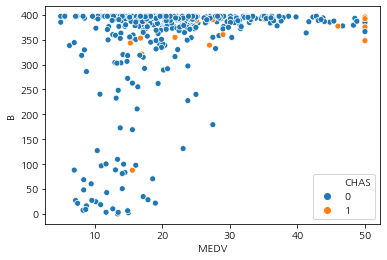

In [26]:
sns.scatterplot(x="MEDV", y="B",hue="CHAS", data=bh)

집값과 흑인인구의 비율 그래프에 강 조망여부를 더해 그려본 결과 흑인인구가 많은 지역이 강변에 위치함을 알 수 있었다.

### 가설2. 범죄율에 따라 집값 변화가 존재할 것이다.

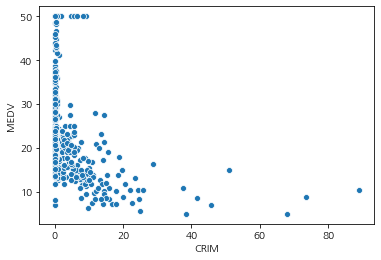

In [27]:
# 범죄율과 집값의 관계
sns.scatterplot(x="CRIM", y="MEDV", data=bh)

그럼 혹시, 흑인 인구비율이 높은 지역의 범죄율이 높고 그것이 집값에 영향을 미치지는 않았을까?

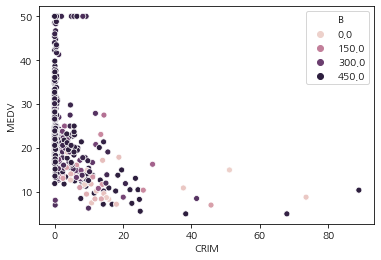

In [28]:
# 흑인비율과 범죄율 그리고 집값의 관계
sns.scatterplot(x="CRIM",y="MEDV",data=bh,hue="B")

위 그래프를 통해 범죄율과 흑인비율에 대한 관련은 찾지 못했으나, 범죄율이 높은 동네일수록 집값이 낮아지는 것은 확실하다.

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, '평균 집값')

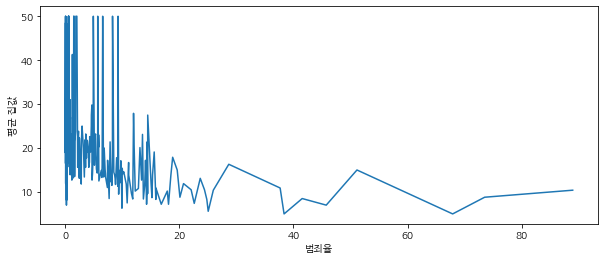

In [29]:
# 범죄율에 따른 집 값 추이
temp=bh[['CRIM','MEDV']]
temp.sort_values(by='CRIM',inplace=True)
plt.rcParams["figure.figsize"] = (10,4)

plt.plot(temp['CRIM'], temp['MEDV'])
plt.xlabel("범죄율");plt.ylabel("평균 집값")

위 그래프로 보아 범죄율이 높을수록 집값은 낮아짐을 명확하게 확인할 수 있었다.

### 가설3. 흑인 비율이 높은 것은 집값에 영향을 주지 못할 것이다.

Text(0, 0.5, '평균 집값')

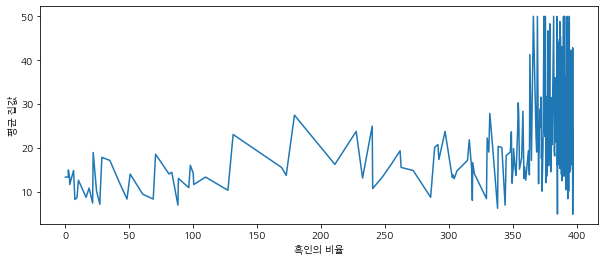

In [30]:
# 흑인 비율에 따른 집값 추이
temp=bh[bh['CHAS']==0][['CHAS','MEDV','B']]
temp.sort_values(by='B',inplace=True)
plt.rcParams["figure.figsize"] = (10,4)

plt.plot(temp['B'], temp['MEDV'])
plt.xlabel("흑인의 비율");plt.ylabel("평균 집값")

Text(0, 0.5, '평균 집값')

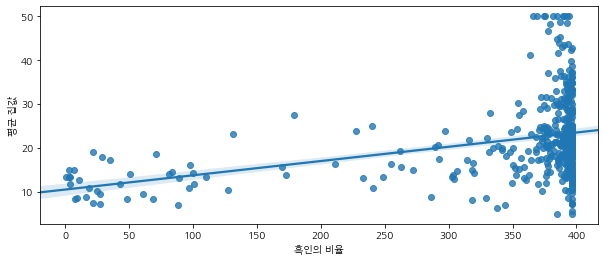

In [31]:
# 흑인 비율에 따른 평균 집값
sns.regplot(x="B",y="MEDV",data=temp)

plt.xlabel("흑인의 비율");plt.ylabel("평균 집값")


위 두 그래프로 보아 비슷한 흑인 비율 안에서도 변동이 심한 것을 알 수 있었고, 흑인 비율이 높은 지역의 집값이 높은 것 또한 알아낼 수 있었다.

### 가설4. NOX(산화 질소 농도)는 사람들이 살아가는데에 부정적인 영향을 미쳤을 것이다.

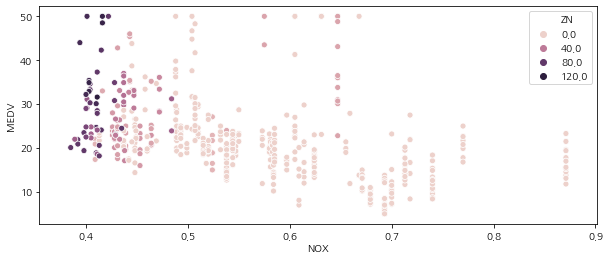

In [32]:
# 산화 질소 농도와 집값 그리고 주거지 비율과의 관계
sns.scatterplot(x="NOX",y="MEDV",data=bh, hue="ZN")

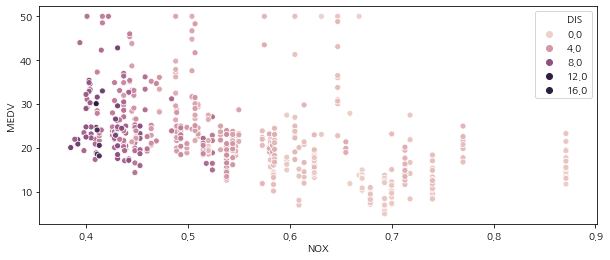

In [33]:
# 산화 질소 농도와 집값 그리고 중심지와의 거리의 관계
sns.scatterplot(x="NOX",y="MEDV",data=bh, hue="DIS")

중심지 근처의 경우 NOX가 높아지게 되는데, 위 두 그래프를 보면 중심지에 가까워질수록 집값이 낮아지고, 주거지 비율이 감소하는 경향을 찾을 수 있었다.

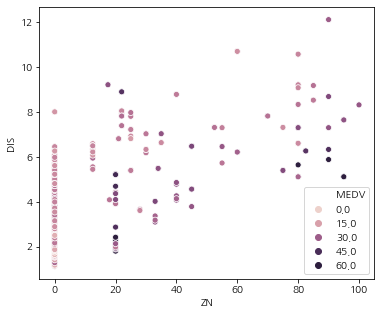

In [34]:
# 주거지 비율과 중심지 거리와의 관계 + 집값
plt.rcParams["figure.figsize"] = (6,5)

sns.scatterplot(x="ZN",y="DIS",data=bh, hue="MEDV")


### AGE 변수의 특징점 찾기

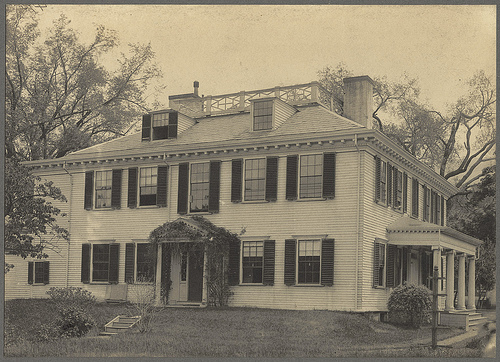

In [35]:
temp=pd.DataFrame(bh['AGE'].value_counts())
temp.reset_index(inplace=True)
temp.head()

,index,AGE
0,100.000000,43
1,96.000000,4
2,98.800003,4
3,87.900002,4
4,97.900002,4


<BarContainer object of 356 artists>

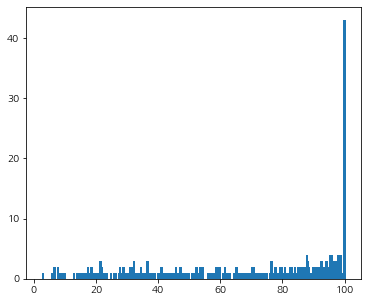

In [36]:
plt.bar(x=temp['index'], height=temp['AGE'])

    오래된 집이 많았던 것으로 추측...
    그럼 오래된 집일 수록 값이 저렴할까?

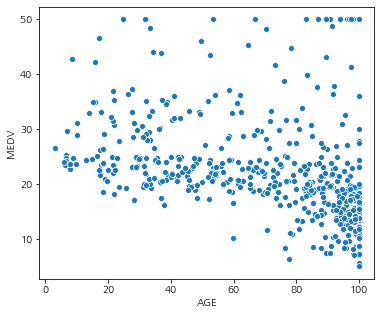

In [37]:
# 노화 건물 비율과 집값 사이의 관계
sns.scatterplot(x="AGE",y="MEDV",data=bh)

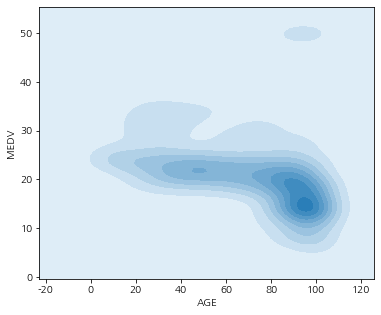

In [38]:
sns.kdeplot(bh['AGE'], bh['MEDV'], shade=True)

위 두 그래프를 보면 점들이 AGE가 커짐에 따라 아래쪽으로 모이는 경향을 보이는 것을 확인 할 수 있다. 즉, 오래된 집일 수록 가격이 낮아진다는 것이다!

# 3. 모델 만들기

### 목표변수와 설명변수 나누기

In [39]:
# 모든 변수
df_x=bh.drop("MEDV", axis=1)
df_y=bh['MEDV']



In [40]:
print(df_y.shape)
print(df_x.shape)


(506,)
(506, 13)


Train과 Test 비율을 7: 3으로 나눈다.

In [41]:
# # x: 설명변수 데이터, y: 목표변수 데이터, test_size: test데이터 비율, random_state:random_seed

train_x, test_x, train_y, test_y = train_test_split(df_x,df_y, test_size=0.3,
                                                               random_state=311)

print("train data X size :{}".format(train_x.shape))
print("train data Y size :{}".format(train_y.shape))

print("test data X size :{}".format(test_x.shape))
print("test data Y size :{}".format(test_y.shape))

train data X size :(354, 13)
train data Y size :(354,)
test data X size :(152, 13)
test data Y size :(152,)


### 3-1 ) LinearRegressor

In [42]:
s=""
for x in train_x.columns:
     s+=x+"+"
s

'CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATIO+B+LSTAT+'

In [43]:
reg_model = smf.ols(formula="MEDV~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+\
DIS+RAD+TAX+PTRATIO+B+LSTAT", data=bh)

reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Sat, 26 Oct 2019   Prob (F-statistic):          6.72e-135
Time:                        02:24:42   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

Durbin-Watson 계수나 각 변수들의 p-value들을 확인 해 본 결과 모델 개선이 필요하다고 판단

### 후진제거법을 이용한 변수 선택

1) 전체 변수

In [44]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select = 5).fit(train_x, train_y)

selected_cols = train_x.columns[rfe.support_]
removed_cols = train_x.columns[~rfe.support_]

print("Selected Varibles : {}".format(selected_cols))
print("Removed Varibles : {}".format(removed_cols))

Selected Varibles : Index(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO'], dtype='object')
Removed Varibles : Index(['CRIM', 'ZN', 'INDUS', 'AGE', 'RAD', 'TAX', 'B', 'LSTAT'], dtype='object')


In [45]:
s=""
for d in selected_cols:
    s+=d+"+"
print(s)

CHAS+NOX+RM+DIS+PTRATIO+


In [46]:
# 선형 회귀 분석
reg_model  =smf.ols(formula="MEDV ~CHAS+NOX+RM+DIS+PTRATIO", data=bh)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     172.9
Date:                Sat, 26 Oct 2019   Prob (F-statistic):          1.46e-106
Time:                        02:24:42   Log-Likelihood:                -1586.2
No. Observations:                 506   AIC:                             3184.
Df Residuals:                     500   BIC:                             3210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.0499      5.026      4.785      0.0

In [47]:
columns=list(selected_cols)

In [48]:
df_x_rfe = df_x[columns]
df_x_rfe_const = add_constant(df_x_rfe)

df_rfe_vif = pd.DataFrame()
df_rfe_vif['variable'] = df_x_rfe_const.columns
df_rfe_vif['VIF'] = [variance_inflation_factor(df_x_rfe_const.values, i) for i in range(df_x_rfe_const.shape[1])]

df_rfe_vif.sort_values("VIF", inplace=True)
df_rfe_vif.round(3)

/home/pirl/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,variable,VIF
1,CHAS,1.040
5,PTRATIO,1.202
3,RM,1.244
4,DIS,2.529
2,NOX,2.603
0,const,408.371


VIF도 괜찮게 나왔다.

In [49]:
scaler = RobustScaler()

cols= columns

np_scaled = scaler.fit_transform(df_x[columns])
df_scaled = pd.DataFrame(np_scaled, columns = cols)

df_scaled['MEDV'] = bh['MEDV']
reg_model_scaled = smf.ols(formula="MEDV ~CHAS+NOX+RM+DIS+PTRATIO", data = df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     172.9
Date:                Sat, 26 Oct 2019   Prob (F-statistic):          1.46e-106
Time:                        02:24:42   Log-Likelihood:                -1586.2
No. Observations:                 506   AIC:                             3184.
Df Residuals:                     500   BIC:                             3210.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.0924      0.307     72.027      0.0

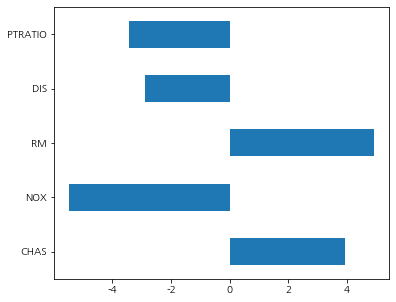

In [50]:
df_reg_scaled_coef = pd.DataFrame({"Coef":reg_result_scaled.params.values[1:]}, index = columns)
df_reg_scaled_coef.plot.barh(y="Coef", legend=False)
plt.show()

### 3-2) Decision Tree

In [51]:
tree_uncustomize = DecisionTreeRegressor(random_state=311)
tree_uncustomize.fit(train_x, train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(tree_uncustomize.score(train_x,train_y)))

# Test 데이터 설명력 
print("Score on test set : {:.3f}".format(tree_uncustomize.score(test_x,test_y)))

Score on training set : 1.000
Score on test set : 0.560


In [52]:
# train 및 test 설명력 결과 저장
train_score = []; test_score=[]

# 잎사귀 최소 자료수를 para_leaf에 저장 (1~19)
para_leaf = [n_leaf*1 for n_leaf in range(1,20,2)]

for v_min_samples_leaf in para_leaf:
    # 각 최소 자료수에 대해서 train과 test의 설명력을 저장함
    tree= DecisionTreeRegressor(random_state =3311, min_samples_leaf=v_min_samples_leaf)
    tree.fit(train_x, train_y)
    train_score.append(tree.score(train_x, train_y))
    test_score.append(tree.score(test_x,test_y))

# 결과 저장
df_score_leaf=pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score

In [53]:
# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.552
1,3,0.974,0.568
2,5,0.919,0.612
3,7,0.908,0.690
4,9,0.898,0.702
5,11,0.881,0.680
6,13,0.867,0.619
7,15,0.858,0.630
8,17,0.848,0.643
9,19,0.835,0.617


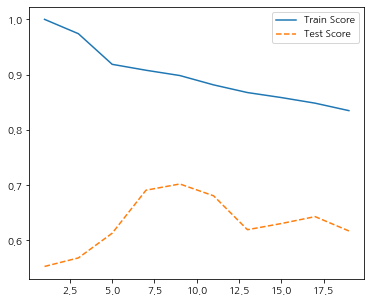

In [54]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle="-",label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()

leaf 는 15 선택

In [55]:
# train 및 test 설명력 결과 저장
train_score = []; test_score=[]

# 잎사귀 최소 자료수를 para_leaf에 저장 (1~19)
para_split = [n_split*2 for n_split in range(2,100)]

for v_min_samples_split in para_split:
    # 각 최소 자료수에 대해서 train과 test의 설명력을 저장함
    tree= DecisionTreeRegressor(random_state =311, min_samples_leaf= 10, min_samples_split=v_min_samples_split)
    tree.fit(train_x, train_y)
    train_score.append(tree.score(train_x,train_y))
    test_score.append(tree.score(test_x, test_y))

# 결과 저장
df_score_split=pd.DataFrame()
df_score_split['MinSamplesSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score

In [56]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.884,0.656
1,6,0.884,0.656
2,8,0.884,0.656
3,10,0.884,0.656
4,12,0.884,0.656
5,14,0.884,0.656
6,16,0.884,0.656
7,18,0.884,0.656
8,20,0.884,0.656
9,22,0.884,0.654


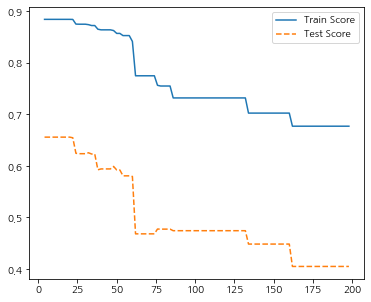

In [57]:
plt.plot(para_split, train_score,linestyle="-", label ="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.legend()

split은 25로 결정

In [58]:
# train 및 test 설명력 결과 저장
train_score = []; test_score=[]

# 잎사귀 최소 자료수를 para_leaf에 저장 (1~19)
para_depth = [depth for depth in range(1,20)]

for v_max_depth in para_depth:
    # 각 최소 자료수에 대해서 train과 test의 설명력을 저장함
    tree= DecisionTreeRegressor(random_state =311,min_samples_leaf=10,
                                min_samples_split=25, max_depth=v_max_depth)
    tree.fit(train_x, train_y)
    train_score.append(tree.score(train_x, train_y))
    test_score.append(tree.score(test_x,test_y))

# 결과 저장
df_score_depth=pd.DataFrame()
df_score_depth['MinSamplesSplit']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score

In [59]:
df_score_depth.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,1,0.516,0.238
1,2,0.743,0.516
2,3,0.804,0.619
3,4,0.842,0.614
4,5,0.865,0.616
5,6,0.873,0.626
6,7,0.875,0.624
7,8,0.875,0.624
8,9,0.875,0.624
9,10,0.875,0.624


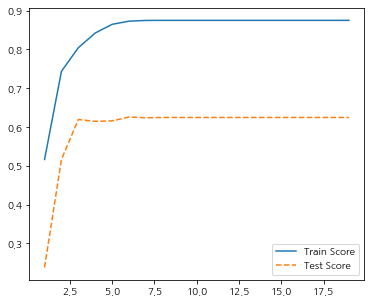

In [60]:
plt.plot(para_depth, train_score, linestyle="-", label ="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.legend()

depth는 5로 결정

In [61]:
tree_final = DecisionTreeRegressor(min_samples_leaf = 10, min_samples_split=25, 
                                   max_depth=5,
                                  random_state=311)
tree_final.fit(train_x,train_y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=25, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=311, splitter='best')

In [62]:
v_feature_name=train_x.columns

In [63]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,RM,0.688
12,LSTAT,0.227
0,CRIM,0.042
8,RAD,0.027
4,NOX,0.007
6,AGE,0.006
7,DIS,0.003
1,ZN,0.000
2,INDUS,0.000
3,CHAS,0.000


Text(0, 0.5, '변수')

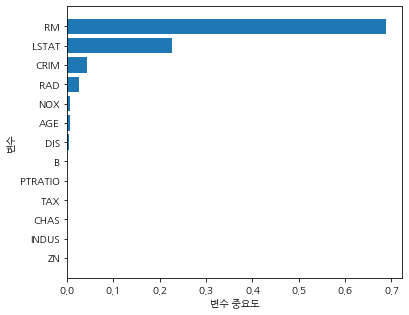

In [64]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel('변수')

In [65]:
print(tree_final.score(test_x,test_y))

0.6156977527772727


### 3-3) RandomForest

In [66]:
rf_uncustomize=RandomForestRegressor(random_state=311)
rf_uncustomize.fit(train_x, train_y)

print("Score on training set : {:.3f}".format(rf_uncustomize.score(train_x, train_y)))
print("Score on test set : {:.3f}".format(rf_uncustomize.score(test_x, test_y)))

Score on training set : 0.980
Score on test set : 0.785


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [67]:
train_score=[]; test_score=[]

para_n_tree=[n_tree*10 for  n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf=RandomForestRegressor(n_estimators=v_n_estimators, random_state=311)
    rf.fit(train_x, train_y)
    train_score.append(rf.score(train_x, train_y))
    test_score.append(rf.score(test_x,test_y))

    
df_score_n = pd.DataFrame()
df_score_n['n_estimators']=para_n_tree
df_score_n['TrainScore']=train_score
df_score_n['TestScore']=test_score
df_score_n['sub']= abs(df_score_n['TrainScore']-df_score_n['TestScore'])
df_score_n.round(3)

,n_estimators,TrainScore,TestScore,sub
0,10,0.980,0.785,0.195
1,20,0.983,0.739,0.245
2,30,0.984,0.745,0.239
3,40,0.984,0.738,0.246
4,50,0.985,0.743,0.242
5,60,0.984,0.745,0.239
6,70,0.985,0.747,0.237
7,80,0.985,0.763,0.222
8,90,0.985,0.762,0.223
9,100,0.986,0.762,0.224


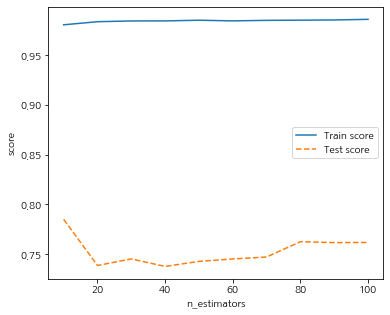

In [68]:
plt.plot(para_n_tree, train_score, linestyle="-", label="Train score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [69]:
train_score=[]; test_score=[]

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestRegressor(random_state=311, n_estimators=100,
                             min_samples_leaf =v_min_samples_leaf)
    rf.fit(train_x, train_y)
    train_score.append(rf.score(train_x,train_y))
    test_score.append(rf.score(test_x,test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSamplesLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score
df_score_leaf['sub']= abs(df_score_leaf['TrainScore']-df_score_leaf['TestScore'])


df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore,sub
0,1,0.986,0.762,0.224
1,2,0.974,0.771,0.203
2,3,0.955,0.773,0.182
3,4,0.935,0.772,0.162
4,5,0.920,0.776,0.144
5,6,0.910,0.775,0.135
6,7,0.899,0.764,0.135
7,8,0.891,0.758,0.133
8,9,0.883,0.748,0.135
9,10,0.877,0.738,0.139


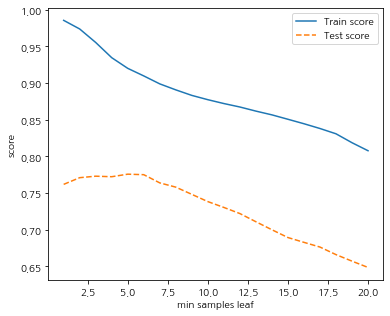

In [70]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [71]:
train_score=[]; test_score=[]

para_split = [n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf=RandomForestRegressor(random_state=311, n_estimators=100,
                             min_samples_leaf = 6, 
                            min_samples_split=v_min_samples_split)
    rf.fit(train_x, train_y)
    train_score.append(rf.score(train_x, train_y))
    test_score.append(rf.score(test_x, test_y))

df_score_split = pd.DataFrame()
df_score_split['MinSamplesLeaf']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score
df_score_split['sub']=abs(df_score_split['TrainScore']-df_score_split['TestScore'])

df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore,sub
0,4,0.910,0.775,0.135
1,6,0.910,0.775,0.135
2,8,0.910,0.775,0.135
3,10,0.910,0.775,0.135
4,12,0.910,0.775,0.135
5,14,0.906,0.770,0.135
6,16,0.902,0.766,0.136
7,18,0.897,0.759,0.139
8,20,0.894,0.753,0.140
9,22,0.891,0.749,0.142


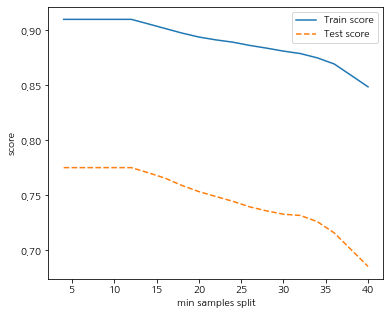

In [72]:
plt.plot(para_split, train_score, linestyle="-", label="Train score")
plt.plot(para_split, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [73]:
train_score=[]; test_score=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf=RandomForestRegressor(random_state=311, n_estimators=100,
                             min_samples_leaf=6, min_samples_split=12,
                             max_depth=v_max_depth)
    rf.fit(train_x, train_y)
    train_score.append(rf.score(train_x, train_y))
    test_score.append(rf.score(test_x, test_y))

df_score_depth = pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score
df_score_depth['sub']=abs(df_score_depth['TrainScore']-df_score_depth['TestScore'])
df_score_depth.round(3)

,Depth,TrainScore,TestScore,sub
0,1,0.597,0.432,0.165
1,2,0.783,0.636,0.147
2,3,0.856,0.734,0.122
3,4,0.885,0.758,0.127
4,5,0.899,0.768,0.131
5,6,0.906,0.772,0.134
6,7,0.909,0.774,0.135
7,8,0.910,0.775,0.135
8,9,0.910,0.775,0.135
9,10,0.910,0.775,0.135


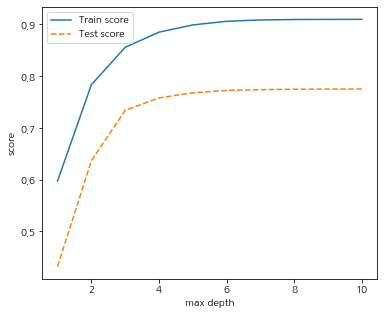

In [74]:
plt.plot(para_depth, train_score, linestyle="-", label="Train score")
plt.plot(para_depth, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()

In [75]:
rf_final = RandomForestRegressor(random_state=311, n_estimators=100,
                                 min_samples_leaf=6,
                                 min_samples_split=12, max_depth=4)
rf_final.fit(train_x, train_y)

print("Score on training set :{:.3f}".format(rf_final.score(train_x, train_y)))
print("Score on test set : {:.3f}".format(rf_final.score(test_x, test_y)))

Score on training set :0.885
Score on test set : 0.758


In [98]:
rf_final

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=12,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=311, verbose=0,
                      warm_start=False)

In [76]:
df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,RM,0.585
12,LSTAT,0.320
0,CRIM,0.033
7,DIS,0.021
4,NOX,0.015
6,AGE,0.009
10,PTRATIO,0.008
8,RAD,0.002
9,TAX,0.002
11,B,0.002


Text(0, 0.5, '변수')

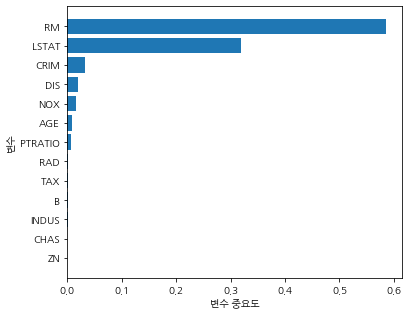

In [77]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 3-4) Gradient Boosting

In [78]:
rf_uncustomize=GradientBoostingRegressor(random_state=311)
rf_uncustomize.fit(train_x,train_y)

print("Score on training set : {:.3f}".format(rf_uncustomize.score(train_x, train_y)))
print("Score on test set : {:.3f}".format(rf_uncustomize.score(test_x, test_y)))

Score on training set : 0.983
Score on test set : 0.799


In [79]:
train_score=[]; test_score=[]

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingRegressor(random_state=311, n_estimators=v_n_estimators)
    gb.fit(train_x,train_y)
    train_score.append(gb.score(train_x, train_y))
    test_score.append(gb.score(test_x,test_y))
    
df_score_n = pd.DataFrame()
df_score_n['n_estimators']=para_n_tree
df_score_n['TrainScore']=train_score
df_score_n['TestScore']=test_score

df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.787,0.645
1,20,0.919,0.741
2,30,0.949,0.769
3,40,0.962,0.780
4,50,0.968,0.787
5,60,0.973,0.790
6,70,0.977,0.795
7,80,0.979,0.797
8,90,0.981,0.797
9,100,0.983,0.799


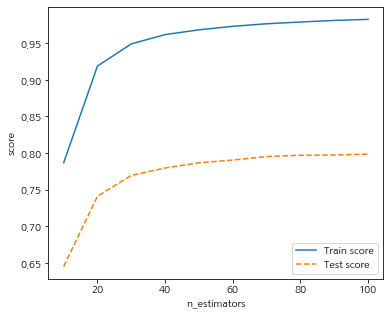

In [80]:
plt.plot(para_n_tree, train_score, linestyle="-", label="Train score")
plt.plot(para_n_tree, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()

In [81]:
train_score=[]; test_score=[]

para_leaf = [n_leaf * 1 for n_leaf in range(1,50,3)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingRegressor(random_state=311, n_estimators=100, 
                                  min_samples_leaf=v_min_samples_leaf)
    gb.fit(train_x, train_y)
    train_score.append(gb.score(train_x, train_y))
    test_score.append(gb.score(test_x, test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf['MinSampelsLeaf']=para_leaf
df_score_leaf['TrainScore']=train_score
df_score_leaf['TestScore']=test_score
df_score_leaf['sub']=abs(df_score_leaf['TrainScore']-df_score_leaf['TestScore'])

df_score_leaf.round(3)

,MinSampelsLeaf,TrainScore,TestScore,sub
0,1,0.983,0.799,0.184
1,4,0.980,0.816,0.164
2,7,0.972,0.836,0.136
3,10,0.966,0.843,0.123
4,13,0.959,0.795,0.165
5,16,0.954,0.793,0.161
6,19,0.949,0.801,0.148
7,22,0.944,0.792,0.152
8,25,0.939,0.767,0.172
9,28,0.932,0.769,0.162


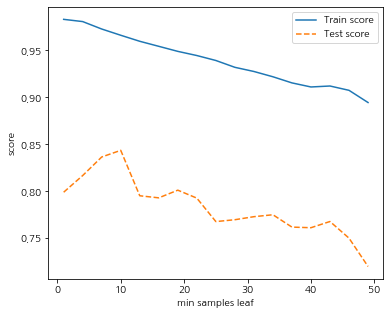

In [82]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()

In [83]:
train_score=[]; test_score=[]

para_split = [n_split * 2 for n_split in range(1,21)]

for v_min_samples_split in para_split:
    gb = GradientBoostingRegressor(random_state=311, n_estimators=100, 
                                  min_samples_leaf=10, min_samples_split=v_min_samples_split)
    gb.fit(train_x, train_y)
    train_score.append(gb.score(train_x, train_y))
    test_score.append(gb.score(test_x, test_y))
    
df_score_split = pd.DataFrame()
df_score_split['MinSampelsSplit']=para_split
df_score_split['TrainScore']=train_score
df_score_split['TestScore']=test_score
df_score_split['sub']=abs(df_score_split['TrainScore']-df_score_split['TestScore'])

df_score_split.round(3)

,MinSampelsSplit,TrainScore,TestScore,sub
0,2,0.966,0.843,0.123
1,4,0.966,0.843,0.123
2,6,0.966,0.843,0.123
3,8,0.966,0.843,0.123
4,10,0.966,0.843,0.123
5,12,0.966,0.843,0.123
6,14,0.966,0.843,0.123
7,16,0.966,0.843,0.123
8,18,0.966,0.843,0.123
9,20,0.966,0.843,0.123


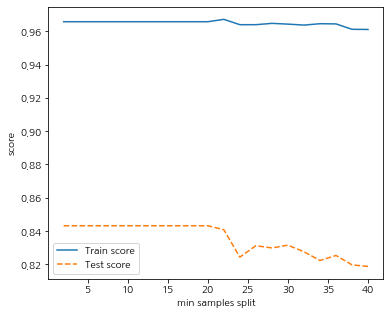

In [84]:
plt.plot(para_split, train_score, linestyle="-", label="Train score")
plt.plot(para_split, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()

In [85]:
train_score=[]; test_score=[]

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingRegressor(random_state=311, n_estimators=10, 
                                  min_samples_leaf=10, min_samples_split=20,
                                  max_depth=v_max_depth)
    gb.fit(train_x, train_y)
    train_score.append(gb.score(train_x, train_y))
    test_score.append(gb.score(test_x, test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth['Depth']=para_depth
df_score_depth['TrainScore']=train_score
df_score_depth['TestScore']=test_score
df_score_depth['sub']=abs(df_score_depth['TrainScore']-df_score_depth['TestScore'])

df_score_depth.round(3)

,Depth,TrainScore,TestScore,sub
0,1,0.547,0.497,0.050
1,2,0.693,0.629,0.064
2,3,0.739,0.647,0.092
3,4,0.766,0.664,0.103
4,5,0.781,0.662,0.120
5,6,0.789,0.667,0.122
6,7,0.792,0.668,0.124
7,8,0.793,0.669,0.124
8,9,0.793,0.669,0.124
9,10,0.793,0.669,0.124


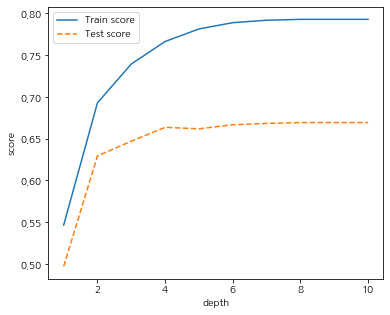

In [86]:
plt.plot(para_depth, train_score, linestyle="-", label="Train score")
plt.plot(para_depth, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

In [87]:
train_score=[]; test_score=[]

para_lr = [lr*0.01 for lr in range(1,50,2)]

for v_learning_rate in para_lr:
    gb = GradientBoostingRegressor(random_state=311, n_estimators=100, 
                                  min_samples_leaf=10, min_samples_split=20,
                                  max_depth=6, learning_rate=v_learning_rate)
    gb.fit(train_x, train_y)
    train_score.append(gb.score(train_x, train_y))
    test_score.append(gb.score(test_x, test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr['learning rate']=para_lr
df_score_lr['TrainScore']=train_score
df_score_lr['TestScore']=test_score
df_score_lr['sub']=abs(df_score_lr['TestScore']-df_score_lr['TrainScore'])

df_score_lr.round(3)

,learning rate,TrainScore,TestScore,sub
0,0.01,0.779,0.663,0.116
1,0.03,0.953,0.810,0.143
2,0.05,0.975,0.812,0.162
3,0.07,0.984,0.815,0.169
4,0.09,0.989,0.805,0.185
5,0.11,0.992,0.805,0.187
6,0.13,0.994,0.799,0.196
7,0.15,0.996,0.800,0.196
8,0.17,0.997,0.806,0.191
9,0.19,0.998,0.804,0.194


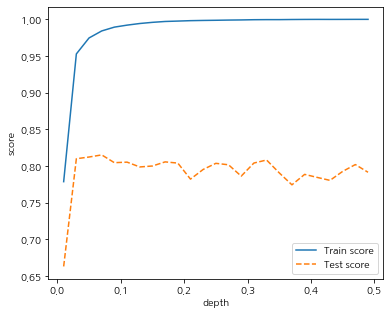

In [88]:
plt.plot(para_lr, train_score, linestyle="-", label="Train score")
plt.plot(para_lr, test_score, linestyle="--", label="Test score")
plt.ylabel("score"); plt.xlabel("depth")
plt.legend()

In [89]:
gb_final = GradientBoostingRegressor(random_state=311, n_estimators=100,
                                     min_samples_leaf=10, 
                                     min_samples_split=20, max_depth=4,
                                     learning_rate=0.07)
gb_final.fit(train_x, train_y)

print("Score on training set :{:.3f}".format(gb_final.score(train_x, train_y)))
print("Score on test set : {:.3f}".format(gb_final.score(test_x, test_y)))

Score on training set :0.970
Score on test set : 0.816


In [99]:
gb_final

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=20,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=311, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [90]:
v_feature_name=train_x.columns

df_importance=pd.DataFrame()
df_importance['Feature']=v_feature_name
df_importance['Importance']=rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,RM,0.585
12,LSTAT,0.320
0,CRIM,0.033
7,DIS,0.021
4,NOX,0.015
6,AGE,0.009
10,PTRATIO,0.008
8,RAD,0.002
9,TAX,0.002
11,B,0.002


Text(0, 0.5, '변수')

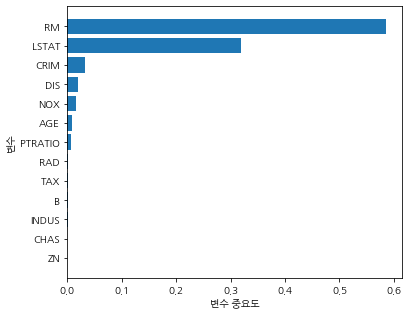

In [91]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))

plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [92]:
models=["회귀분석","의사결정나무","랜덤포레스트","그래디언트 부스팅"]
mse,rmse,mae,mape=[],[],[],[]

In [93]:
lr_y_pred=reg_result.predict(test_x)


mse.append(mean_squared_error(test_y, lr_y_pred))
rmse.append(root_mean_squared_error(test_y, lr_y_pred))
mae.append(mean_absolute_error(test_y, lr_y_pred))
mape.append(mean_absolute_percentage_error(test_y, lr_y_pred))

In [94]:
dt_y_pred=tree_final.predict(test_x)


mse.append(mean_squared_error(test_y, dt_y_pred))
rmse.append(root_mean_squared_error(test_y, dt_y_pred))
mae.append(mean_absolute_error(test_y, dt_y_pred))
mape.append(mean_absolute_percentage_error(test_y, dt_y_pred))

In [95]:
rf_y_pred=rf_final.predict(test_x)


mse.append(mean_squared_error(test_y, rf_y_pred))
rmse.append(root_mean_squared_error(test_y, rf_y_pred))
mae.append(mean_absolute_error(test_y, rf_y_pred))
mape.append(mean_absolute_percentage_error(test_y, rf_y_pred))

In [96]:
gb_y_pred=gb_final.predict(test_x)


mse.append(mean_squared_error(test_y, gb_y_pred))
rmse.append(root_mean_squared_error(test_y, gb_y_pred))
mae.append(mean_absolute_error(test_y, gb_y_pred))
mape.append(mean_absolute_percentage_error(test_y, gb_y_pred))

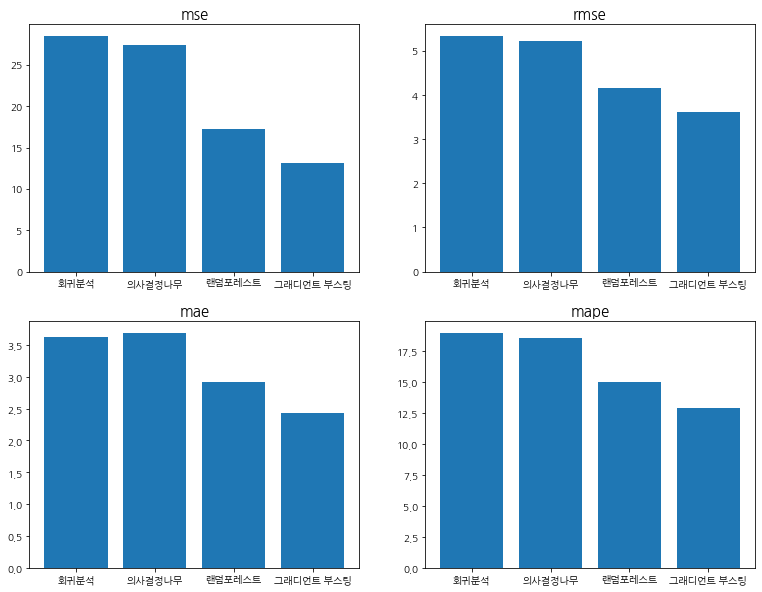

In [97]:
fig,ax=plt.subplots(2,2,figsize=(13,10))
ax[0,0].bar(models,mse)
ax[0,0].set_title("mse").set_fontsize(15)

ax[0,1].bar(models,rmse)
ax[0,1].set_title("rmse").set_fontsize(15)

ax[1,0].bar(models,mae)
ax[1,0].set_title("mae").set_fontsize(15)

ax[1,1].bar(models,mape)
ax[1,1].set_title("mape").set_fontsize(15)

# 최종 결과
모든 변수를 넣어 회귀분석, 의사결정나무, 랜덤포레스트, 그래디언트 부스팅 모델을 생성해본결과 모델의 정확도를 검정하는 mse, rmse, mae, mape 모두 그레디언트 부스팅 모델이 가장 성능이 좋다고 평가되었다.